In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from tqdm.notebook import tqdm, trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

OUTPUT_DIM = 10
EPOCH_NUM = 4

In [56]:
translate_dict = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel',
}.keys()

In [77]:
transformer = transforms.Compose([
    transforms.Resize([225, 225]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [78]:
import os


def transform_resize(tensor):
    new_tensor = torch.reshape(tensor, (3, -1))  # Reshape tensor to size (3, -1)
    return new_tensor



def prepare():
    data_prepare = []
    cwd = "./archive/raw-img"
    counter = 0
    for index, directory in tqdm(enumerate(translate_dict)):
        for root, dirs,files in os.walk(cwd + "/" + directory):
            for file in files:
                 with Image.open(f"./{cwd}/{directory}/{file}") as pic:
                    try:
                        data_prepare.append((transformer(pic), index))
                    except:
                        counter +=1
                        print(file)

    return data_prepare, counter

data, counter = prepare()
print(counter)

0it [00:00, ?it/s]

eb36b70d2efd073ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.png
ea35b80a2df1033ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.png
e83db7072afd013ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg
e835b50620f0013ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.png
ea34b10b21f5083ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg
ea35b80a2df1053ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.png
e835b50620f7083ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.png
e835b50620f7093ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.png
ea35b80a2df1043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.png
e835b50620f0073ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.png
eb32b8072bfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png
eb32b6092afd043ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png
ea37b4072af2093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png
eb32b40820fd063ed1584d05fb1d4e9fe777ead218ac104497f

In [79]:
random.shuffle(data)

data = data[:int(len(data)*0.4)]

BATCH_SIZE = 100
TRAIN_SIZE = int(0.8 * len(data))

train_data = data[:TRAIN_SIZE]
test_data = data[TRAIN_SIZE:]

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [80]:
class AnimalClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(AnimalClassifier, self).__init__()
        self.model = resnet18(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )

    def forward(self, val):
        resnet_out = self.fc1(self.model(val))
        return self.fc2(resnet_out)

In [81]:
model = AnimalClassifier(OUTPUT_DIM)

In [82]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [83]:
loss_hist = {'train': [], 'test': []}
acc_hist = {'train': [], 'test': []}
loaders = {'train': train_dataloader, 'test': test_dataloader}

for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):

    for phase in loaders.keys():

        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.
        running_acc = 0.

        for (x, y) in tqdm(loaders[phase], desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(x)
                y_pred_class = y_pred.argmax(dim=1)

                loss_value = loss_function(y_pred, y)

                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()

            running_loss += loss_value.item()
            running_acc += (y_pred_class == y.data).float().mean().data.cpu().numpy()

        epoch_loss = running_loss / len(loaders[phase])
        epoch_acc = running_acc / len(loaders[phase])

        acc_hist[phase].append(epoch_acc)
        loss_hist[phase].append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 1.3474 Acc: 0.5960 

Epoch: 1. Phase: test:   0%|          | 0/21 [00:00<?, ?it/s]

test Loss: 0.6199 Acc: 0.8681 

Epoch: 2. Phase: train:   0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.5646 Acc: 0.8498 

Epoch: 2. Phase: test:   0%|          | 0/21 [00:00<?, ?it/s]

test Loss: 0.3671 Acc: 0.9049 

Epoch: 3. Phase: train:   0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.4130 Acc: 0.8820 

Epoch: 3. Phase: test:   0%|          | 0/21 [00:00<?, ?it/s]

test Loss: 0.2899 Acc: 0.9183 

Epoch: 4. Phase: train:   0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3439 Acc: 0.9032 

Epoch: 4. Phase: test:   0%|          | 0/21 [00:00<?, ?it/s]

test Loss: 0.2561 Acc: 0.9260 

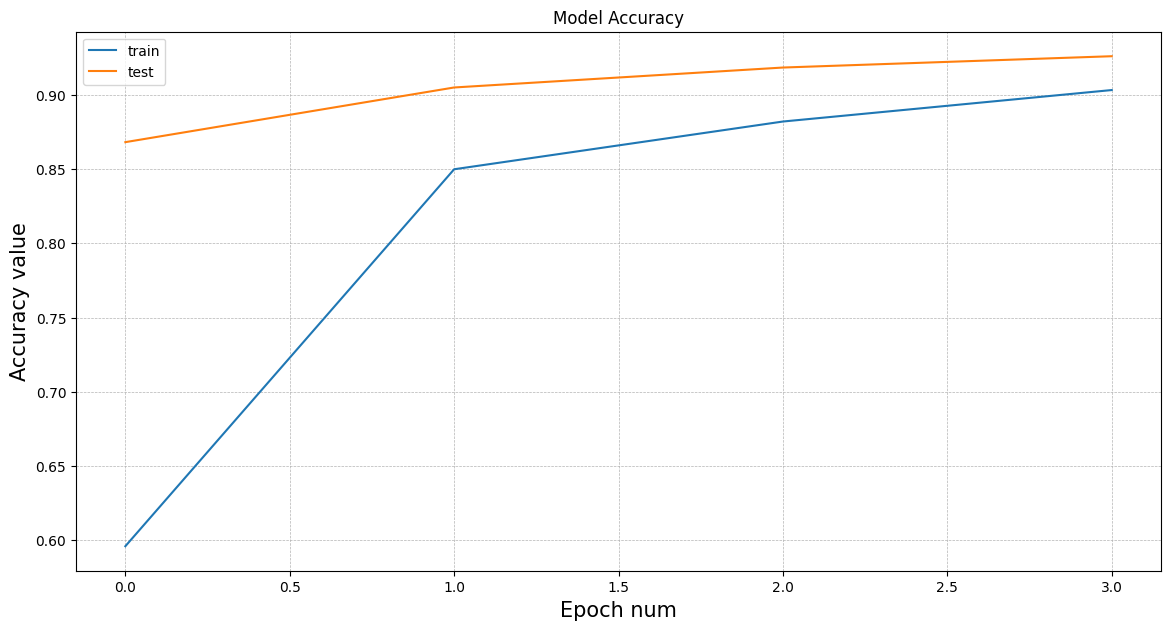

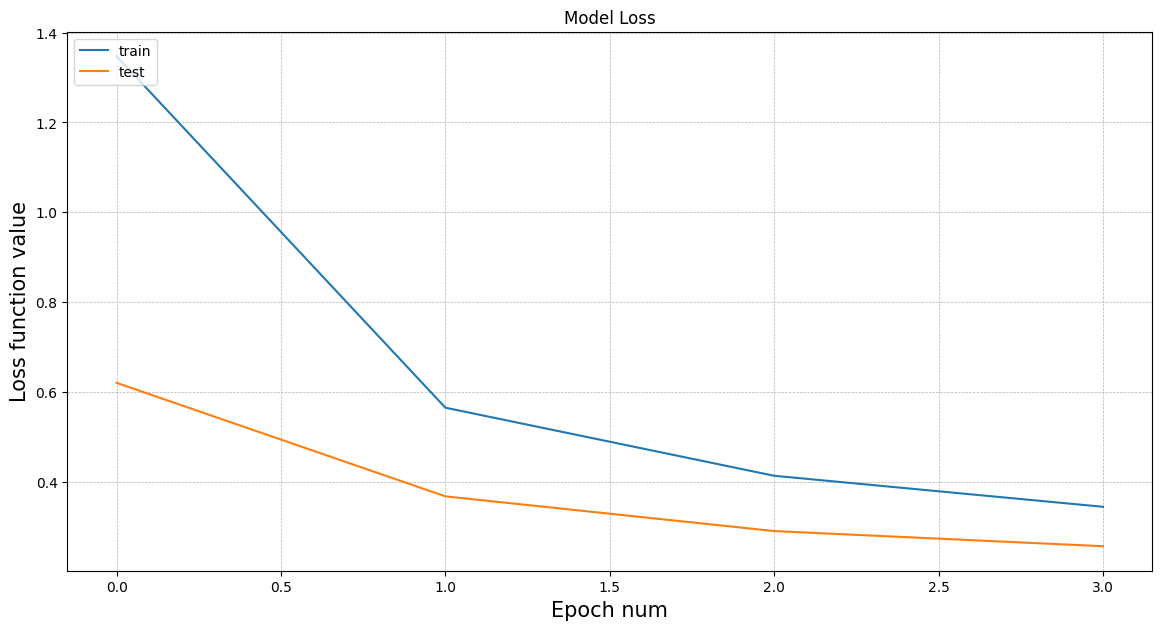

In [84]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()